In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

import inputs
import models
import shooting

from __future__ import division

# Calibrating the Adamopoulos and Restuccia(2014) paper with $x$, classical version

This notebook solves for a model with two-sided heterogeneity and firm size when capital also enters the production function.

In particular, the production function takes the form:

$$F(x,y,l,r,k) = A\kappa( (kx)^{\rho} \eta + (1-\eta) (yl/r)^{\rho})^{\gamma/\rho}$$

The solution for optimal capital ($k(x,y,l,r)$) can be found in the Capital.ipynb notebook.

First, workers and firms are created - we assume worker skill is very homogeneous, and that firm skill follows a lognormal distribution.

Then the model is solved for Rich ($A=1,R=0.13099$) and Poor ($A=0.5105,R=0.83684$) countries and then comapres the solution.

In [61]:
# define some workers skill
x, a, b = sym.var('x, a, b')
skill_cdf = (x - a) / (b - a)
skill_params = {'a': 0.99, 'b': 1.01}
skill_bounds = [skill_params['a'], skill_params['b']]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some firms lognorm.pdf(x, s) = 1 / (s*x*sqrt(2*pi)) * exp(-1/2*(log(x)/s)**2)
y, mu2, sigma2 = sym.var('y, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y) - mu2) / (sym.sqrt(2) * sigma2))
productivity_params = {'mu2': -1.0, 'sigma2': 4.66}
productivity_bounds = [1e-3, 10.0]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

## 1.Solving for the Rich Country

In [62]:
# Developped country

R, l, r, rho, gamma, eta, L, A, kapa = sym.var('R, l, r, rho, gamma, eta, L, A, kapa')

# First set k to the optimum (look at Capital notebook)
#k_star = (2*6**(-0.5)*(A*eta**2*kapa*x**0.5/R)**0.5*sym.cos(0.333333333333333*sym.acos(3*6**0.5*x**(-0.5)*(l*x*y/r)**0.25*(R*x**(-0.5)/(A*eta**2*kapa))**0.5*(-eta + 1)/(2*eta))))**(4)

F = A*kapa*(eta*x**rho + (1- eta)*(y*(l/r))**rho)**(gamma/rho)

F_params = {'R':0.13099, 'rho':0.25, 'gamma':0.5, 'eta':0.89, 'L':4.2, 'A': 1.0, 'kapa':1.0}

In [63]:
# Try out positive
model = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

In [64]:
solver.solve(10.0, tol=1e-6, number_knots=6000, atol=1e-15, rtol=1e-12, integrator='lsoda')

Success! All workers and firms are matched


In [65]:
solver.solution.head()

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.990000,0.001000,20.625935,0.000939,0.844510
0.990003,0.001000,20.621522,0.000939,0.844512
0.990007,0.001000,20.617110,0.000940,0.844513
0.990010,0.001001,20.612698,0.000940,0.844514
0.990013,0.001001,20.608287,0.000940,0.844516


In [66]:
# Saving results into sol1
sol1 = solver.solution

xs = sol1.index.values
ys = sol1['$\\mu(x)$'].values
thetas = sol1['$\\theta(x)$'].values
ws = sol1['$w(x)$'].values
# For capital lambdify k_star
#eval_k = sym.lambdify((x,y,l,r,A,kapa,eta,R), k_star)
#ks = []
#for a in range(len(xs)):
#    ks.append(eval_k(xs[a],ys[a],thetas[a],1,1,1,0.89,0.13099))

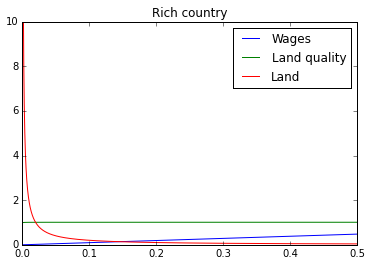

In [67]:
# Plotting the solution
plt.plot(ys, ws, label="Wages")
plt.plot(ys, xs, label="Land quality")
plt.plot(ys, thetas, label="Land")
plt.legend(loc='best')
plt.xlim(0,0.5)
plt.ylim(0.0,10.0)
plt.title("Rich country")
plt.show()

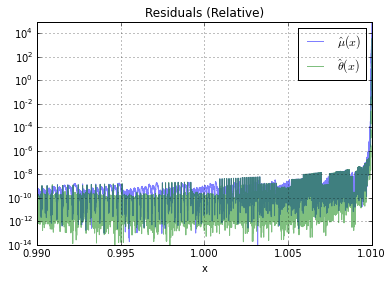

In [68]:
#Plotting the Residuals
solver.residuals.plot(logy=True, alpha=0.5)
plt.title("Residuals (Relative)")
plt.show()

## 2.Solving for the Poor Country

In [69]:
# Not-so-Developped country

F_params2 = {'R':0.83684, 'rho':0.25, 'gamma':0.5, 'eta':0.89, 'L':5.46, 'A': 0.5105, 'kapa':1.0}

F = A*kapa*(eta*x**rho + (1- eta)*(y*(l/r))**rho)**(gamma/rho)

model2 = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params2)

solver = shooting.ShootingSolver(model=model2)

In [70]:
solver.solve(1.0, tol=1e-6, number_knots=6000, atol=1e-15, rtol=1e-12, integrator='lsoda')

Success! All workers and firms are matched


In [71]:
solver.solution.head()

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.990000,0.001000,20.625936,0.000479,0.431123
0.990003,0.001000,20.621524,0.000480,0.431123
0.990007,0.001000,20.617112,0.000480,0.431124
0.990010,0.001001,20.612700,0.000480,0.431125
0.990013,0.001001,20.608288,0.000480,0.431125


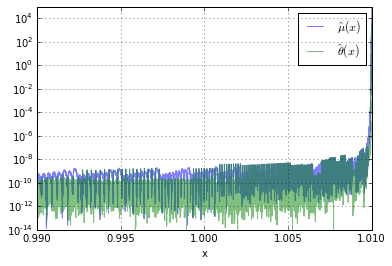

In [75]:
solver.residuals.plot(logy=True, alpha=0.5)
plt.show()

In [76]:
# Saving results into sol2
sol2 = solver.solution

xs2 = sol2.index.values
ys2 = sol2['$\\mu(x)$'].values
thetas2 = sol2['$\\theta(x)$'].values
ws2 = sol2['$w(x)$'].values
#ks2 = []
#for a in range(len(xs2)):
#    ks2.append(eval_k(xs2[a],ys2[a],thetas2[a],1,0.5105,1,0.89,0.83684))

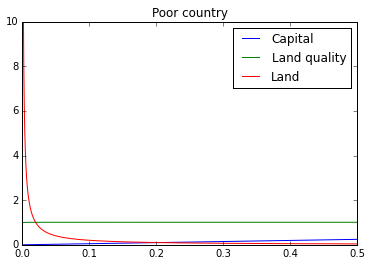

In [77]:
plt.plot(ys2, ws2, label="Capital")
plt.plot(ys2, xs2, label="Land quality")
plt.plot(ys2, thetas2, label="Land")
plt.legend(loc='best')
plt.xlim(0.0,0.5)
plt.ylim(0.0,10.0)
plt.title("Poor country")
plt.show()

## 3. Comparing Solutions


### All graphs have in the horizontal axis *farmer skill* ($y$)

Solutions

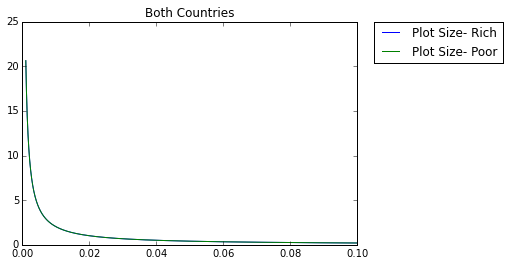

In [82]:
#plt.plot(ys, ws, label="Capital - Rich")
plt.plot(ys, thetas, label="Plot Size- Rich")
#plt.plot(ys2, ws2, label="Capital - Poor")
plt.plot(ys2, thetas2, label="Plot Size- Poor")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0.0,0.1)
plt.title("Both Countries")
plt.show()

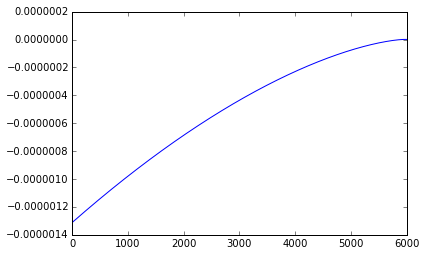

In [83]:
theta_diff = thetas-thetas2
plt.plot(theta_diff)
plt.show()

Plot size ($\theta$)

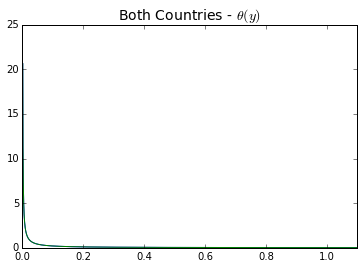

In [84]:
#ax1.plot(xs, ys, label="Land quality- Rich")
plt.plot(ys, thetas, label="Labour- Rich")
#ax1.plot(xs2, ks2, label="Capital - Poor")
#ax1.plot(xs2, ys2, label="Land quality- Poor")
plt.plot(ys2, thetas2, label="Labour- Poor")
#ax1.plot(xs, ks, label="Capital - Rich")

#plt.ylim(0,17)
plt.xlim(0,1.1)
plt.title("Both Countries - $\\theta(y)$", size=14)
plt.show()

Capital

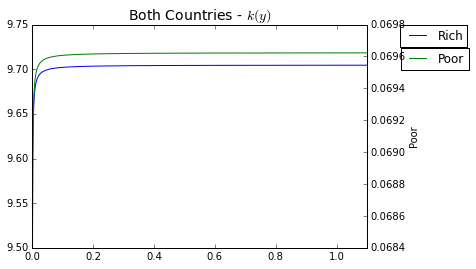

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(ys, ks, label="Rich")

ax2 = ax1.twinx()
plt.plot(ys2, ks2, label="Poor", c='g')
ax2.set_ylabel('Poor')

ax1.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.065, 0.95), loc=2, borderaxespad=1)
plt.xlim(0,1.1)
plt.title("Both Countries - $k(y)$", size=14)
plt.show()

## Extra bit: Distributions

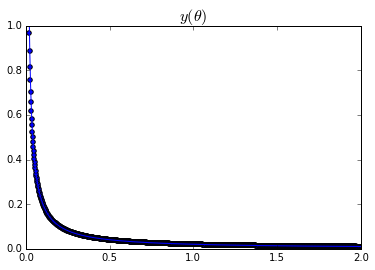

In [85]:
from scipy.interpolate import PchipInterpolator

# It is necessay for interpolation to order theta in ascending order
sateht = thetas[::-1]
sy = ys[::-1]
y_spl = PchipInterpolator(thetas[::-1], ys[::-1])
plt.plot(thetas, y_spl(thetas))
plt.scatter(thetas,ys)
plt.xlim(0,2)
plt.ylim(0,1)
plt.title("$y (\\theta)$", size=16)
plt.show()

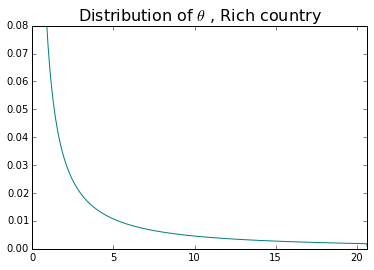

In [86]:
theta_grid  = np.linspace(min(thetas), max(thetas), 1000)
theta_dis = []
for th in theta_grid:
    theta_dis.append(firms.evaluate_pdf(y_spl(th),norm=False)*(abs((y_spl.derivative()(th)))))
plt.plot(theta_grid, theta_dis, c='teal')
plt.xlim(min(thetas),max(thetas))
plt.ylim(0,0.08)
plt.title("Distribution of $\\theta$ , Rich country", size=16)
plt.show()

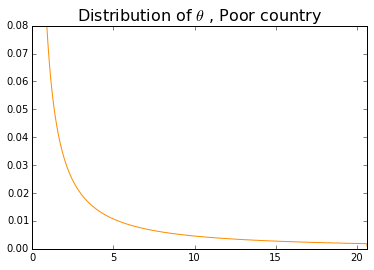

In [87]:
sateht2 = thetas2[::-1]
sy2 = ys2[::-1]
y_spl_P = PchipInterpolator(thetas2[::-1], ys2[::-1])

theta_grid2  = np.linspace(min(thetas2), max(thetas2), 1000)
theta_dis2 = []
for th in theta_grid:
    theta_dis2.append(firms.evaluate_pdf(y_spl_P(th),norm=False)*(abs((y_spl_P.derivative()(th)))))
plt.plot(theta_grid2, theta_dis2, c='darkorange')
plt.xlim(min(thetas2),max(thetas2))
plt.ylim(0,0.08)
plt.title("Distribution of $\\theta$ , Poor country", size=16)
plt.show()

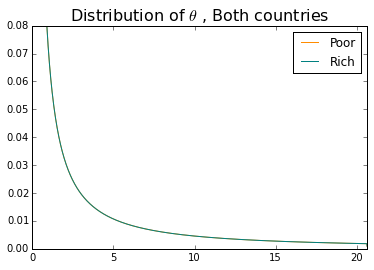

In [88]:
plt.plot(theta_grid2, theta_dis2, c='darkorange', label='Poor')
plt.plot(theta_grid, theta_dis, c='teal', label='Rich')
 
plt.legend(loc='best')
plt.xlim(0,max(thetas2))
plt.ylim(0,0.08)
plt.title("Distribution of $\\theta$ , Both countries", size=16)
plt.show()


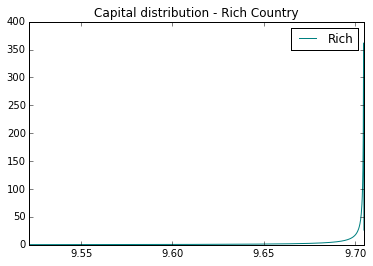

In [105]:
k_range = np.linspace(min(ks), max(ks), 1000)
k_range2 = np.linspace(min(ks2), max(ks2), 1000)

y_k = PchipInterpolator(ks, ys)
y_k2 = PchipInterpolator(ks2, ys2)
k_dis = []
k_dis2 = []

for k in k_range:
    k_dis.append(firms.evaluate_pdf(y_k(k),norm=False)*(abs((y_k.derivative()(k)))))
for k in k_range2:
    k_dis2.append(firms.evaluate_pdf(y_k2(k),norm=False)*(abs((y_k2.derivative()(k)))))

plt.plot(k_range, k_dis, c='teal', label='Rich')
plt.xlim(min(ks),max(ks))
plt.legend(loc='best')
plt.title("Capital distribution - Rich Country")
plt.show()

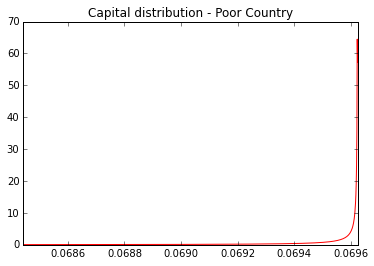

In [100]:
plt.plot(k_range2, k_dis2, c='red', label='Poor')
plt.title("Capital distribution - Poor Country")
plt.xlim(min(ks2),max(ks2))
plt.show()

In [128]:
k_ratio =[]
k_ratio2 = []
k_ratio_dis = []
k_ratio_dis2 = []
for i in range(len(ks)):
    k_ratio.append(ks[i]/thetas[i])
    k_ratio_dis.append(firms.evaluate_pdf(ys[i])*k_ratio[i])
    k_ratio2.append(ks2[i]/thetas2[i])
    k_ratio_dis2.append(firms.evaluate_pdf(ys2[i])*k_ratio2[i])
sum(k_ratio_dis),sum(k_ratio_dis2)

(48700.875057920792, 280.13715883232021)

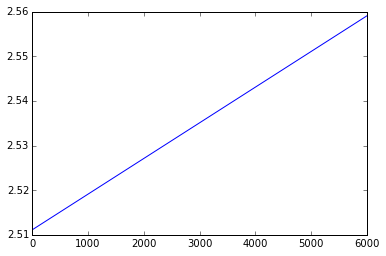

In [140]:
pis = sol1['$\\pi(x)$'].values
plt.plot(pis)
plt.show()